# IMPORTS E INSTALAÇÕES
---

In [ ]:
%pip install -r requirements.txt

In [1]:
# from ucimlrepo import fetch_ucirepo # ...

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical

# import tensorflow as tf
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


# import funcoes_auxiliares as faux
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# FUNÇÕES AUXILIARES
---

In [2]:
def busca_registros_faltantes(df):
    # Verifica quais colunas têm pelo menos um dado faltante
    colunas_com_faltantes = df.columns[df.isnull().any()]

    # Filtra o dataframe original para incluir apenas as colunas com faltantes
    subdataframe = df[colunas_com_faltantes]

    # Verifica quais linhas têm pelo menos um dado faltante no subdataframe
    linhas_com_faltantes = subdataframe.index[subdataframe.isnull().any(axis=1)]

    # Filtra novamente o subdataframe para incluir apenas as linhas com faltantes
    subdataframe = subdataframe.loc[linhas_com_faltantes]

    return subdataframe

def plot_historico(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # Imprime a curva de aprendizado
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # Imprime a curva de acurácia
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

  #fig.savefig('/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/' + title)
  #plt.show()

def correlacao_e_visualizacao(dataset, target_column, method='pearson', threshold=0.6):
    # Calcular a correlação
    correlacao = dataset.corrwith(dataset[target_column], method=method)

    # Selecionar colunas com base no limiar de correlação
    colunas_selecionadas = correlacao[(correlacao >= threshold) | (correlacao <= -threshold)].index

    # Criar um DataFrame com as correlações
    correlations = pd.DataFrame({method.capitalize(): correlacao})

    # Criar um mapa de calor com as correlações originais
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(data=correlations, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f"Correlação com '{target_column}'")

    # Criar um novo DataFrame com as colunas selecionadas
    dataset_filtrado = dataset[colunas_selecionadas]

    # Calcular as correlações para o DataFrame filtrado
    correlacao_filtrada = dataset_filtrado.corrwith(dataset[target_column], method=method)

    # Criar um mapa de calor para as correlações filtradas
    sns.heatmap(data=pd.DataFrame({method.capitalize(): correlacao_filtrada}), annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f"Correlação de {method.capitalize()} (Filtrada)")

    plt.tight_layout()
    plt.show()

def exibir_metricas_classificacao(classe_teste, previsoes):
    # Calcular métricas
    acuracia = accuracy_score(classe_teste, previsoes)
    precisao = precision_score(classe_teste, previsoes, average="micro")
    recall = recall_score(classe_teste, previsoes, average="micro")
    f1score = f1_score(classe_teste, previsoes, average="micro")

    # Criar um DataFrame para exibir as métricas
    df = pd.DataFrame({
        'Acurácia': [acuracia],
        'Precisão': [precisao],
        'Recall': [recall],
        'F1-Score': [f1score]
    })

    return df

def exibir_matriz_confusao(classe_teste, previsoes):
    matriz = confusion_matrix(classe_teste, previsoes)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = np.arange(1, len(val_loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history, metric_name='categorical_accuracy'):
    history_dict = history.history
    acc_values = history_dict[metric_name]
    val_acc_values = history_dict['val_' + metric_name]

    epochs = np.arange(1, len(val_acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def normalize_dataset(dataset, columns_to_exclude):
    # Crie um DataFrame com as colunas a serem normalizadas
    df_to_normalize = dataset.drop(columns=columns_to_exclude)
    
    # Realize a normalização Min-Max nas colunas selecionadas
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=df_to_normalize.columns)
    
    # Combine o DataFrame normalizado com as colunas originais
    dataset_normalized = pd.concat([df_normalized, dataset[columns_to_exclude]], axis=1)
    
    return dataset_normalized


# EXTRAÇÃO DOS DADOS
---

## Limpeza dos dados

In [3]:
# Buscando de csv local
dataset = pd.read_csv("dados-automoveis.csv", sep=",", encoding='latin-1')

# Uma descrição estatística dos dados
dataset.isna().sum()

# dataset.shape

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [4]:
dataset_relevante = dataset.drop(columns=["dateCrawled","name", "vehicleType", "seller","offerType","abtest", "monthOfRegistration", "dateCreated", "nrOfPictures", "postalCode", "lastSeen"])

In [5]:
# Uma descrição estatística dos dados
dataset_relevante.isna().sum()

price                     0
yearOfRegistration        0
gearbox               20209
powerPS                   0
model                 20484
kilometer                 0
fuelType              33386
brand                     0
notRepairedDamage     72060
dtype: int64

In [6]:
dataset_filtrado = dataset_relevante.dropna(subset=["notRepairedDamage", "fuelType", "model", "gearbox"])

In [7]:
# drop price and normalized-losses from features
registro_faltantes = busca_registros_faltantes(dataset_filtrado)
registro_faltantes

""


## Verificando correlação

correção da lógica pendente! → não está certo!

In [ ]:
# print(dataset_filtrado.dtypes)

In [21]:
# # Lista das colunas que você deseja codificar
# colunas_para_codificar = ['gearbox', 'model', 'fuelType','brand', 'notRepairedDamage', 'lastSeen']

# # Crie um objeto LabelEncoder
# label_encoder = LabelEncoder()

# # Dataset somente para verificar correlação
# dataset_correlacacao = dataset_filtrado.copy()

# # Itere pelas colunas e aplique o Label Encoding
# for coluna in colunas_para_codificar:
#     dataset_correlacacao[coluna] = label_encoder.fit_transform(dataset_correlacacao[coluna])

# dataset_correlacacao

In [ ]:
# correlacao_e_visualizacao(dataset_correlacacao, 'price', method='spearman', threshold=0.4)

In [24]:
# # Lista de colunas que deseja manter
# colunas_desejadas = ['kilometer', 'powerPS', 'yearOfRegistration']

# # Sobrescreva o dataset com as colunas desejadas (caso queira usar para algum teste de modelo)
# dataset_filtrado_correlacacao = dataset_correlacacao[colunas_desejadas]


# TRANSFORMAÇÃO DOS DADOS
---

## Obtendo Classe e Previsores

In [25]:
dataset_filtrado.head()

,price,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
3,1500,2001,manuell,75,golf,150000,benzin,volkswagen,nein
4,3600,2008,manuell,69,fabia,90000,diesel,skoda,nein
5,650,1995,manuell,102,3er,150000,benzin,bmw,ja
6,2200,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein
7,0,1980,manuell,50,andere,40000,benzin,volkswagen,nein


In [8]:
# Previsores
X = dataset_filtrado.drop(columns=["price"]).values

# Classe
Y = dataset_filtrado["price"].values

## Codificação 

In [9]:
labelencoder_classe = LabelEncoder()
Y = labelencoder_classe.fit_transform(Y)

In [10]:
onehotencorder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(sparse_output=False), [1, 3, 5, 6, 7])], remainder='passthrough')
X = onehotencorder.fit_transform(X)

## Normalizando

In [11]:
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# CARREGANDO DADOS (MODELO)
---

##  Separando Teste e Treino

In [12]:
# Base de treino e teste
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25)

## Criando modelo

In [13]:
classificador = Sequential()
classificador.add(Dense(units = 2, activation = 'softmax', kernel_initializer = 'random_uniform', input_dim = train_x.shape[1]))
classificador.add(Dense(units = 1, activation = 'sigmoid'))

## Compilando o modelo

In [14]:
classificador.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
classificador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 608       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 611 (2.39 KB)
Trainable params: 611 (2.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Treinando o modelo

In [15]:
history = classificador.fit(train_x, train_y, batch_size = 5000, epochs = 100, validation_split=0.2)

Epoch 1/100
33/33 [==============================] - 1s 14ms/step - loss: 483.8352 - binary_accuracy: 0.0142 - val_loss: 369.4309 - val_binary_accuracy: 0.0143
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 269.2852 - binary_accuracy: 0.0142 - val_loss: 163.0579 - val_binary_accuracy: 0.0143
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 73.7570 - binary_accuracy: 0.0133 - val_loss: -20.9674 - val_binary_accuracy: 0.0040
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: -99.3838 - binary_accuracy: 0.0018 - val_loss: -183.3241 - val_binary_accuracy: 0.0012
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: -253.1938 - binary_accuracy: 0.0015 - val_loss: -329.1093 - val_binary_accuracy: 0.0012
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: -392.6039 - binary_accuracy: 0.0015 - val_loss: -462.8408 - val_binary_accuracy: 0.0012
Epoch 7/100
33/33 [======================

# MÉTRICAS E DESEMPENHO
---

In [16]:
# Realizando previsões
previsoes_teste = classificador.predict(test_x)
previsoes_teste = (previsoes_teste > 0.5)

2103/2103 [==============================] - 3s 2ms/step


In [17]:
exibir_metricas_classificacao(test_y, previsoes_teste)

,Acurácia,Precisão,Recall,F1-Score
0,0.001427,0.001427,0.001427,0.001427


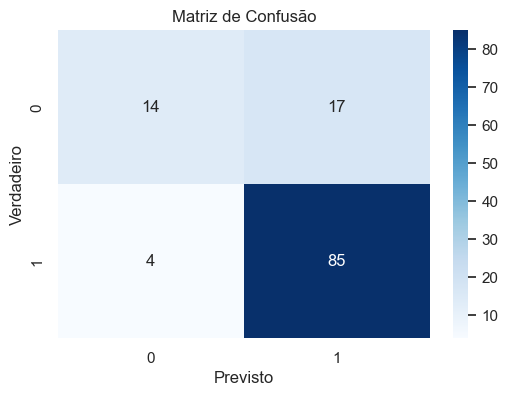

In [27]:
exibir_matriz_confusao(test_y, previsoes_teste)

# EXPORTANDO DADOS
---

In [29]:
import os

# Diretório atual
save_dir = os.getcwd()

# Caminho para os arquivos
arquitetura_path = os.path.join(save_dir, "arquitetura_rede.json")
pesos_path = os.path.join(save_dir, "pesos_rede.h5")

# Salve a arquitetura em JSON
arquitetura = classificador.to_json()
with open(arquitetura_path, "w") as json_file:
    json_file.write(arquitetura)

# Salve os pesos da rede
classificador.save_weights(pesos_path)

print(f"Arquivos salvos em: {save_dir}")

Arquivos salvos em: c:\Users\Mathe\projetos\EoC-AI-IFES\lista3-previsao-emprestimo
